In [60]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import argparse
import os

In [3]:
import numpy as np
import pandas as pd

In [4]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [6]:
import tensorflow as tf

In [7]:
from keras.layers import Lambda, Input, Dense

In [51]:
# MNIST dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [54]:
image_size = x_train.shape
original_dim = image_size[1] * image_size[2]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [55]:
x_train.shape

(60000, 28, 28)

In [56]:
# network parameters
intermediate_dim = 512
batch_size = 128
input_shape = (batch_size, original_dim)
latent_dim = 2
epochs = 50

In [57]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [58]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr 
    an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [59]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, name='z')([z_mean, z_log_var])

ValueError: Dimensions must be equal, but are 2 and 128 for 'z_6/mul_1' (op: 'Mul') with input shapes: [?,128,2], [?,128].

In [39]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 1680000)      0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          860160512   encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_3[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_3[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [40]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [41]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_5 (Dense)              (None, 1680000)           861840000 
Total params: 861,841,536
Trainable params: 861,841,536
Non-trainable params: 0
_________________________________________________________________


In [42]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [43]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_sign"):
    """Plots labels and LC ATLAS signatures as function 
    of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "signs_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    sign_size = (18, 12)
    figure = np.zeros((digit_size[0] * n, digit_size[1] * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(sign_size[0], sign_size[1])
            figure[i * sign_size[0]: (i + 1) * sign_size[0],
                   j * sign_size[1]: (j + 1) * sign_size[1]] = digit

    plt.figure(figsize=(10, 10))
    start_range = sign_size[0] // 2
    end_range = n * sign_size[0] + start_range + 1
    pixel_range = np.arange(start_range, end_range, sign_size[0])
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [44]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [46]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [47]:
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

ValueError: Error when checking input: expected encoder_input to have shape (1680000,) but got array with shape (784,)

In [72]:
x_test.shape

(10000, 784)

In [75]:
x_test_encoded = encoder.predict(x_test) #, batch_size=batch_size)

In [77]:
len(x_test_encoded)

3

In [78]:
x_test_encoded[0].shape

(10000, 2)

In [80]:
y_test.shape

(10000,)

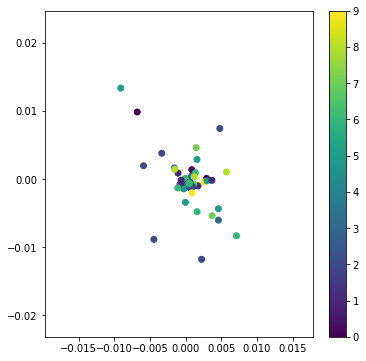

In [79]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=y_test)
plt.colorbar()
plt.show()

In [20]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [61]:
df_mira = pd.read_csv('ATLAS_LC/MIRA_features_table.csv')
signature_cols = [col for col in df_mira.columns if 'Signature' in col]
signature_cols += ['OBJID', 'filter', 'CLASS']
df_mira = df_mira[signature_cols]

In [62]:
df_mpulse = pd.read_csv('ATLAS_LC/MPULSE_features_table.csv')[signature_cols]
df_dbf = pd.read_csv('ATLAS_LC/DBF_features_table.csv')[signature_cols]
df_lpv = pd.read_csv('ATLAS_LC/LPV_features_table.csv')[signature_cols]
df_dbh = pd.read_csv('ATLAS_LC/DBH_features_table.csv')[signature_cols]
df_pulse = pd.read_csv('ATLAS_LC/PULSE_features_table.csv')[signature_cols]
df_nsine = pd.read_csv('ATLAS_LC/NSINE_features_table.csv')[signature_cols]
df_sine = pd.read_csv('ATLAS_LC/SINE_features_table.csv')[signature_cols]
df_msine = pd.read_csv('ATLAS_LC/MSINE_features_table.csv')[signature_cols]
df_cbh = pd.read_csv('ATLAS_LC/CBH_features_table.csv')[signature_cols]
df_cbf = pd.read_csv('ATLAS_LC/CBF_features_table.csv')[signature_cols]
df_irr = pd.read_csv('ATLAS_LC/IRR_features_table.csv')[signature_cols]

In [63]:
df_mira.columns

Index([u'Signature_ph_00_mag_00', u'Signature_ph_00_mag_01',
       u'Signature_ph_00_mag_02', u'Signature_ph_00_mag_03',
       u'Signature_ph_00_mag_04', u'Signature_ph_00_mag_05',
       u'Signature_ph_00_mag_06', u'Signature_ph_00_mag_07',
       u'Signature_ph_00_mag_08', u'Signature_ph_00_mag_09',
       ...
       u'Signature_ph_17_mag_05', u'Signature_ph_17_mag_06',
       u'Signature_ph_17_mag_07', u'Signature_ph_17_mag_08',
       u'Signature_ph_17_mag_09', u'Signature_ph_17_mag_10',
       u'Signature_ph_17_mag_11', u'OBJID', u'filter', u'CLASS'],
      dtype='object', length=219)

In [64]:
full_data = pd.concat([df_mira, df_mpulse, df_dbf, df_lpv, df_dbh, df_pulse, 
                       df_nsine, df_sine, df_msine, df_cbf, df_cbh], sort=False)
signature_cols = [col for col in df_mira.columns if 'Signature' in col]
X = full_data[signature_cols].values

In [65]:
Y = full_data['CLASS'].values

In [24]:
del(df_mira)
del(df_dbf)
del(df_lpv)
del(df_dbh)
del(df_pulse)
del(df_nsine)
del(df_sine)
del(df_msine)
del(df_cbh)
del(df_cbf)
del(df_irr)

In [25]:
data = X.reshape(X.shape[0], 18, 12)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_test = train_test_split(data, test_size=0.50, random_state=21)

In [28]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [38]:
print(x_train.shape)
print(x_test.shape)

(181266, 216)
(181266, 216)


#from keras.callbacks import TensorBoard

In [36]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1, 2'

In [37]:
#with tf.device(':/gpu:2'):
vae.fit(x_test, x_test,
                epochs=300,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))#,
                #callbacks=[TensorBoard(log_dir='/users/bsanchez/tensorboard_logs/autoencoder')])

Train on 181266 samples, validate on 181266 samples
Epoch 1/300
180352/181266 [============================>.] - ETA: 0s - loss: 0.0113

InvalidArgumentError: Incompatible shapes: [128,216] vs. [18,216]
	 [[Node: training/RMSprop/gradients/loss/dense_8_loss/logistic_loss/mul_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _class=["loc:@train...ad/Reshape"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/RMSprop/gradients/loss/dense_8_loss/logistic_loss/mul_grad/Shape, training/RMSprop/gradients/loss/dense_8_loss/logistic_loss/mul_grad/Shape_1)]]
	 [[Node: loss/mul/_67 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_545_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
# encode and decode some lightcurves
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
decoded_imgs_full = autoencoder.predict(X_test)

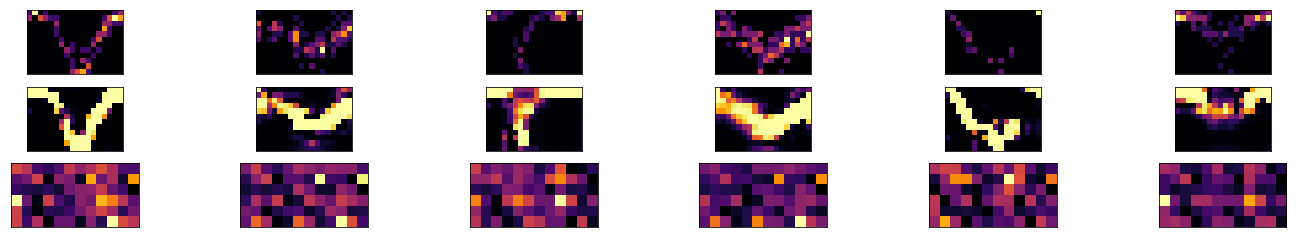

In [96]:
n = 6  # how many digits we will display
plt.figure(figsize=(24, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    j = np.random.randint(0, high=len(X_test))
    plt.imshow(X_test[j, :, :, 0].T, cmap='inferno')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_full[j, :, :, 0].T, cmap='inferno')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded view
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(encoded_imgs[j].reshape(12, 6).T, cmap='inferno')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [99]:
# encode every data 
encoded_imgs = encoder.predict(data)
encoded_imgs.shape

(362532, 3, 3, 8)

In [100]:
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs.shape

(362532, 18, 12, 1)

In [103]:
np.save('deep_encoded_signatures.npy', encoded_imgs)
np.save('deep_decoded_signatures.npy', decoded_imgs)